In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import logit, expit
import torch

from funcs import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


This notebook is set up to demonstrate cross validation for choosing hyperparameters for linear model search and a train,test,validate approach for a non-linear model hyperparameters. 

In [2]:
bl = tiers2blacklist([ 1,1,1, 2,2,2,2,2,2,2,2,3, 0, 0])

node_order = ['medSkept',
 'overpar',
 'parentExpert',
 'diseaseRare',
 'diseaseSevere',
 'vaccEff',
 'vaccTox',
 'vaccStrain',
 'vaccDanger',
 'infantImmLimCap',
 'infantImmWeak',
 'vaccIntent',
 'hb',
 'nat']

df_raw = pd.read_csv("data/s1-data.csv")
df_raw = df_raw[node_order]

df_raw.head()

,medSkept,overpar,parentExpert,diseaseRare,diseaseSevere,vaccEff,vaccTox,vaccStrain,vaccDanger,infantImmLimCap,infantImmWeak,vaccIntent,hb,nat
0,-1.500000,0.0,0.0,0.6,2.2,1.75,-2.75,-1.0,-2.75,0.0,-1.2,2.6,1.50,-0.166667
1,2.166667,1.0,1.2,-3.0,3.0,-1.25,2.75,3.0,1.25,2.6,3.0,-0.4,0.50,1.000000
2,-0.166667,0.4,0.0,-1.2,2.0,1.00,-2.00,-0.8,-1.50,-0.2,0.4,1.6,0.25,-0.666667
3,-0.166667,0.0,-0.4,0.0,0.6,0.00,-0.50,0.0,-0.50,0.4,0.2,0.0,1.00,0.166667
4,0.166667,0.2,-0.2,-0.4,1.6,-0.50,1.25,0.8,0.75,-0.4,0.8,0.0,2.25,0.000000


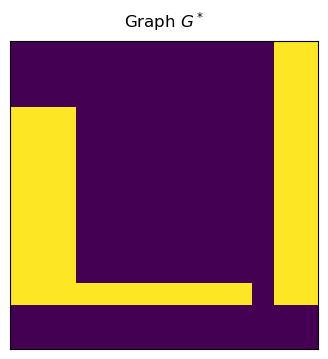

In [3]:
visualize_adj_matrix(bl)

Conducting cross-validation to find best penalty parameter and weight threshold (simplified example).

In [23]:
from sklearn.model_selection import KFold

df = df_raw.apply(standardize)
train_set, test_set = train_test_split(df.to_numpy(), test_size=0.2, random_state = 123)

scores = []
kf = KFold(n_splits=3)
for lambda1 in [.005, .02, .1]:
    for thresh in [.05, .15, .3]:
        for train, test in kf.split(train_set):
            train = train_set[train,:]
            test = train_set[test,:]

            model = DagmaLinear2(loss_type='l2') # create a linear model with least squares loss
            W_est = model.fit(train, lambda1=0.02, w_threshold = thresh, exclude_edges = adj_to_edge_tuple(bl)) # fit the model with L1 reg. (coeff. 0.02)
            score = np.mean((test - model.predict(torch.tensor(test)).detach().numpy())**2) # RMSE
            scores.append((lambda1, thresh, score))

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

  0%|          | 0/180000.0 [00:00<?, ?it/s]

In [24]:
pd.DataFrame(scores, columns = ["lambda1", "threshold", "score"])

,lambda1,threshold,score
0,0.005,0.05,0.625870
1,0.005,0.05,0.639237
2,0.005,0.05,0.627812
3,0.005,0.15,0.648597
4,0.005,0.15,0.656356
5,0.005,0.15,0.645869
6,0.005,0.30,0.688581
7,0.005,0.30,0.696941
8,0.005,0.30,0.720212
9,0.020,0.05,0.625870


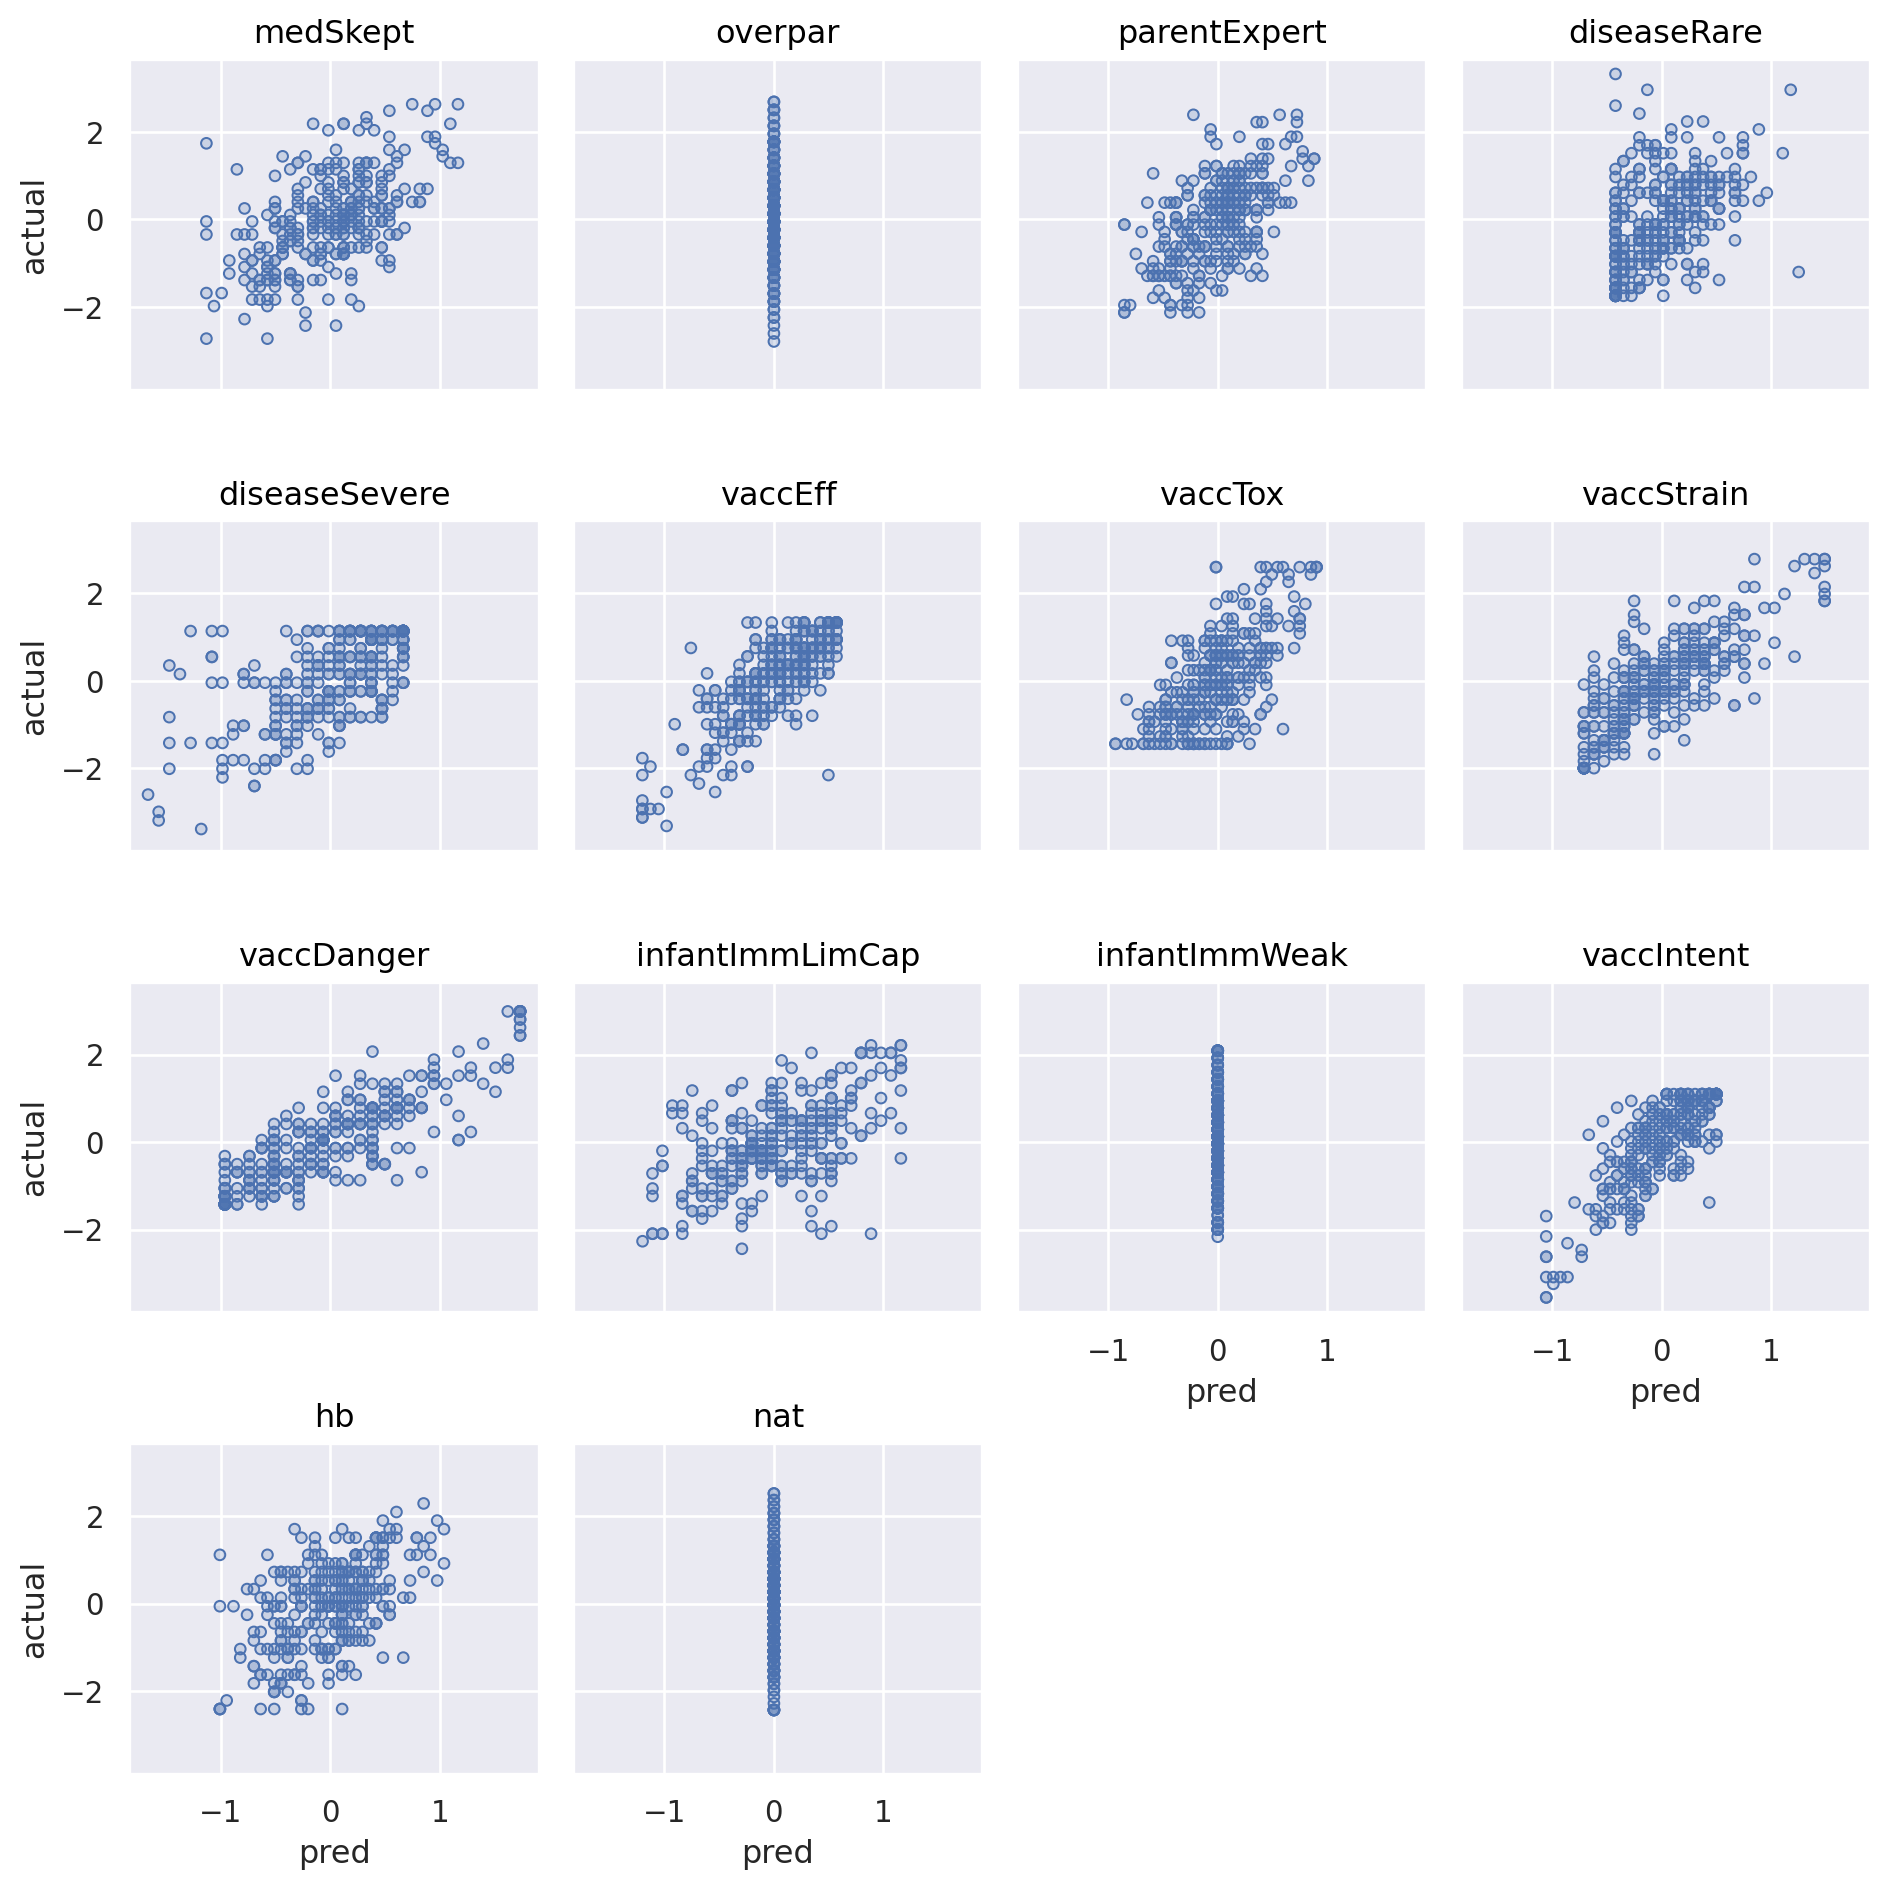

In [45]:
import seaborn.objects as so

preds = pd.DataFrame(model.predict(torch.tensor(test)).detach().numpy(), columns = node_order).melt(value_name = "pred")
preds_obs = pd.DataFrame(test, columns = node_order).melt(value_name = "actual").assign(pred = preds.pred)

p = so.Plot(preds_obs, "pred", "actual").add(so.Dots())
p.facet("variable", wrap = 4).layout(size = (10, 10))


## Nonlinear model

Can assess penalty and threshold terms for non-linear model using a (train, validate, test) split setup. This still takes a while to run (i.e. a few hours on my A100; could take a very long time on CPU).

In [20]:
df = df_raw.apply(standardize)
train, validate, test = np.split(df.sample(frac=1).to_numpy(), [int(.6*len(df)), int(.8*len(df))])


In [ ]:
scores = []

for lambda1 in [.02, .1]:
    for thresh in [.05, .15, .3]:
        
        eq_model = DagmaMLP2(dims=[14, 10, 1], bias=True, dtype=torch.double, blackadj = torch.tensor(bl)) # create the model for the structural equations, in this case MLPs
        model = DagmaNonlinear(eq_model, dtype=torch.double) # create the model for DAG learning
        W_est = model.fit(torch.tensor(train), lambda1=lambda1, lambda2=0.005, w_threshold=thresh) # fit the model with L1 reg. (coeff. 0.02) and L2 reg. (coeff. 0.005)

        score = np.mean((validate - model.model(torch.tensor(validate)).detach().numpy())**2)
        scores.append((lambda1, thresh, score))


In [ ]:
pd.DataFrame(scores, columns = ["lambda1", "threshold", "score"])